# Demo: Understanding Tokenization Through Real Examples

**Skill Pair 1: Text Tokenization & Vocabulary Building**

**Scenario:** Customer support message understanding system  
**Estimated Time:** 7 minutes

---

## Why This Matters

Your customer support team is overwhelmed with repetitive questions. You're building a chatbot to handle common inquiries, but first the system needs to "read" customer messages. The way you break text into tokens will determine whether your chatbot can handle typos, new product names, and technical terms it hasn't seen before.

**Key Question:** How do we convert variable-length text into something a neural network can process?

In [1]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully!
PyTorch version: 2.9.0


## Step 1: Motivate Sequence Models - Why Order Matters

Sequential data is fundamentally different from images or tabular data:

- **Images:** Fixed 224×224 grids, spatial relationships
- **Tables:** Fixed columns, row-independent
- **Sequences:** Variable length, **ORDER MATTERS CRITICALLY**

Let's see why order matters:

In [13]:
# Example: Same words, different meanings
sentence1 = "I didn't like it"
sentence2 = "I like it"

# Same words? Let's check
words1 = set(sentence1.lower().replace("'", " ").split())
words2 = set(sentence2.lower().replace("'", " ").split())

print("Sentence 1:", sentence1, "→ Meaning: NEGATIVE")
print("Sentence 2:", sentence2, "→ Meaning: POSITIVE")
print(f"\nWord overlap: {words1 & words2}")
print("\n💡 Insight: A simple bag-of-words model would fail here!")
print("   Sequence models capture the ORDER of words.")

Sentence 1: I didn't like it → Meaning: NEGATIVE
Sentence 2: I like it → Meaning: POSITIVE

Word overlap: {'it', 'like', 'i'}

💡 Insight: A simple bag-of-words model would fail here!
   Sequence models capture the ORDER of words.


### More Examples Where Order Matters

1. **Time Series:** Stock price at 9am vs 4pm
2. **DNA Sequences:** ATGC vs CGTA (completely different proteins)
3. **Customer Messages:** "cancel my order" vs "don't cancel my order"

**Challenge:** Unlike images (fixed size), sequences have **variable length** and can't directly feed into neural networks.

## Step 2: The Challenge - Variable Length Sequences

Neural networks expect fixed-size inputs, but text messages vary wildly in length:

In [14]:
# Example customer messages with different lengths
example_messages = [
    "Help!",
    "I need help with my account.",
    "Can you help me understand why my last order was cancelled and when I might receive a refund?",
    "Hi there, I've been trying to reset my password for the past 30 minutes but the reset link isn't working."
]

print("Message Lengths (in characters):\n")
for i, msg in enumerate(example_messages, 1):
    print(f"{i}. Length: {len(msg):3d} | {msg[:60]}{'...' if len(msg) > 60 else ''}")

print("\n💡 Problem: Neural networks need FIXED-SIZE inputs!")
print("   Solution: Tokenization + Padding/Truncation")

Message Lengths (in characters):

1. Length:   5 | Help!
2. Length:  28 | I need help with my account.
3. Length:  93 | Can you help me understand why my last order was cancelled a...
4. Length: 105 | Hi there, I've been trying to reset my password for the past...

💡 Problem: Neural networks need FIXED-SIZE inputs!
   Solution: Tokenization + Padding/Truncation


## Step 3: Load Customer Messages

Let's load real customer support messages from the Bitext dataset:

In [15]:
# Load the dataset
print("Loading customer support dataset...")
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset", split="train")

# Extract 50 diverse examples
np.random.seed(42)
sample_indices = np.random.choice(len(dataset), size=50, replace=False)
messages = [dataset[int(idx)]['instruction'] for idx in sample_indices]

print(f"\n✓ Loaded {len(messages)} customer messages")
print("\nFirst 5 examples:")
for i, msg in enumerate(messages[:5], 1):
    print(f"{i}. {msg}")

Loading customer support dataset...

✓ Loaded 50 customer messages

First 5 examples:
1. I can't talk with  a human agent
2. I have got to locate hte bills from {{Person Name}}
3. I cannot pay, help me to inform of a problem with payments
4. I want help speaking to customer service
5. I try to see th accepted payment options


## Step 4: Implement Word Tokenization

Let's build a simple word-level tokenizer from scratch:

**The Pipeline:** Text → Tokens → Vocabulary → Indices

In [16]:
class SimpleWordTokenizer:
    """A simple word-level tokenizer."""
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = Counter()
        
        # Special tokens
        self.PAD = '<PAD>'
        self.UNK = '<UNK>'
        
        # Initialize
        self._add_token(self.PAD)
        self._add_token(self.UNK)
        
    def _add_token(self, token):
        """Add a token to vocabulary."""
        if token not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[token] = idx
            self.idx2word[idx] = token
    
    def fit(self, texts, min_freq=2):
        """Build vocabulary from texts."""
        # Count all tokens
        for text in texts:
            tokens = self.tokenize(text)
            self.vocab.update(tokens)
        
        # Add tokens that meet minimum frequency
        for token, count in self.vocab.most_common():
            if count >= min_freq:
                self._add_token(token)
        
        print(f"\n✓ Vocabulary built:")
        print(f"  Total unique tokens seen: {len(self.vocab)}")
        print(f"  Tokens in vocabulary (freq >= {min_freq}): {len(self.word2idx)}")
        print(f"  Special tokens: {self.PAD}, {self.UNK}")
    
    def tokenize(self, text):
        """Split text into tokens (simple whitespace split)."""
        return text.lower().split()
    
    def encode(self, text):
        """Convert text to list of indices."""
        tokens = self.tokenize(text)
        return [self.word2idx.get(token, self.word2idx[self.UNK]) for token in tokens]
    
    def decode(self, indices):
        """Convert indices back to text."""
        return ' '.join([self.idx2word[idx] for idx in indices])
    
    def __len__(self):
        return len(self.word2idx)

# Create and fit tokenizer
tokenizer = SimpleWordTokenizer()
tokenizer.fit(messages, min_freq=2)


✓ Vocabulary built:
  Total unique tokens seen: 173
  Tokens in vocabulary (freq >= 2): 70
  Special tokens: <PAD>, <UNK>


In [17]:
# Show most common tokens
print("\nMost common tokens in customer messages:")
for token, count in tokenizer.vocab.most_common(15):
    in_vocab = "✓" if token in tokenizer.word2idx else "✗"
    print(f"  {in_vocab} '{token}': {count} times")


Most common tokens in customer messages:
  ✓ 'i': 42 times
  ✓ 'to': 35 times
  ✓ 'a': 14 times
  ✓ 'how': 14 times
  ✓ 'can': 13 times
  ✓ 'want': 12 times
  ✓ 'help': 11 times
  ✓ 'the': 11 times
  ✓ 'do': 11 times
  ✓ 'see': 9 times
  ✓ 'know': 9 times
  ✓ 'with': 8 times
  ✓ 'my': 8 times
  ✓ 'of': 6 times
  ✓ 'don't': 6 times


## Step 5: Convert to Indices

Now let's convert text to numerical indices that can be fed into a neural network:

In [18]:
# Example: Tokenize and encode a message
test_message = messages[0]
print(f"Original message:\n  '{test_message}'")

# Tokenize
tokens = tokenizer.tokenize(test_message)
print(f"\nTokens:\n  {tokens}")

# Encode to indices
indices = tokenizer.encode(test_message)
print(f"\nIndices:\n  {indices}")

# Decode back
decoded = tokenizer.decode(indices)
print(f"\nDecoded:\n  '{decoded}'")

# Convert to PyTorch tensor
tensor = torch.tensor(indices)
print(f"\nPyTorch tensor:\n  Shape: {tensor.shape}")
print(f"  Dtype: {tensor.dtype}")
print(f"  Device: {tensor.device}")
print("\n✓ Ready to feed into a neural network!")

Original message:
  'I can't talk with  a human agent'

Tokens:
  ['i', "can't", 'talk', 'with', 'a', 'human', 'agent']

Indices:
  [2, 1, 39, 13, 4, 1, 26]

Decoded:
  'i <UNK> talk with a <UNK> agent'

PyTorch tensor:
  Shape: torch.Size([7])
  Dtype: torch.int64
  Device: cpu

✓ Ready to feed into a neural network!


## Step 6: Discover the Problem - Unknown Words

What happens when we encounter new words not in our vocabulary?

In [19]:
# Test with messages containing new/rare words
new_messages = [
    "I just bought an iPhone-15-Pro but it won't charge",
    "My smartwatch isn't syncing with the app",
    "The deliverydrone dropped my package in the wrong location"
]

print("Testing tokenization with NEW words:\n")
for msg in new_messages:
    tokens = tokenizer.tokenize(msg)
    indices = tokenizer.encode(msg)
    decoded = tokenizer.decode(indices)
    
    # Find unknown tokens
    unk_idx = tokenizer.word2idx[tokenizer.UNK]
    unk_tokens = [tokens[i] for i, idx in enumerate(indices) if idx == unk_idx]
    
    print(f"Message: {msg}")
    print(f"  Unknown words: {unk_tokens if unk_tokens else 'None'}")
    print(f"  Decoded: {decoded}")
    print()

print("💡 Problem: Unknown words are replaced with <UNK>!")
print("   We lose important information like product names.")

Testing tokenization with NEW words:

Message: I just bought an iPhone-15-Pro but it won't charge
  Unknown words: ['just', 'bought', 'an', 'iphone-15-pro', 'but', "won't", 'charge']
  Decoded: i <UNK> <UNK> <UNK> <UNK> <UNK> it <UNK> <UNK>

Message: My smartwatch isn't syncing with the app
  Unknown words: ['smartwatch', "isn't", 'syncing', 'app']
  Decoded: my <UNK> <UNK> <UNK> with the <UNK>

Message: The deliverydrone dropped my package in the wrong location
  Unknown words: ['deliverydrone', 'dropped', 'package', 'in', 'wrong', 'location']
  Decoded: the <UNK> <UNK> my <UNK> <UNK> the <UNK> <UNK>

💡 Problem: Unknown words are replaced with <UNK>!
   We lose important information like product names.


## Step 7: Observe Subword Solution

Modern tokenizers use **subword tokenization** to handle unknown words by breaking them into known pieces:

- **WordPiece** (BERT): Used by BERT models
- **BPE** (Byte-Pair Encoding): Used by GPT models  
- **SentencePiece**: Language-agnostic tokenization

Let's see how BERT's tokenizer handles our problematic cases:

In [20]:
# Load pretrained BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print("Comparing Word-level vs. Subword tokenization:\n")
print("="*80)

for msg in new_messages:
    # Word-level tokenization
    word_tokens = tokenizer.tokenize(msg)
    word_indices = tokenizer.encode(msg)
    word_unk_count = sum(1 for idx in word_indices if idx == tokenizer.word2idx[tokenizer.UNK])
    
    # Subword tokenization
    bert_tokens = bert_tokenizer.tokenize(msg)
    bert_indices = bert_tokenizer.encode(msg, add_special_tokens=True)
    
    print(f"\nMessage: {msg}\n")
    print(f"Word-level ({len(word_tokens)} tokens, {word_unk_count} unknown):")
    print(f"  {word_tokens}")
    
    print(f"\nSubword-level ({len(bert_tokens)} tokens, 0 unknown):")
    print(f"  {bert_tokens}")
    print("-"*80)

print("\n💡 Key Insight: Subword tokenizers break rare words into known pieces!")
print("   'iPhone-15-Pro' → ['iphone', '-', '15', '-', 'pro']")
print("   'smartwatch' → ['smart', '##watch']")

Comparing Word-level vs. Subword tokenization:


Message: I just bought an iPhone-15-Pro but it won't charge

Word-level (9 tokens, 7 unknown):
  ['i', 'just', 'bought', 'an', 'iphone-15-pro', 'but', 'it', "won't", 'charge']

Subword-level (15 tokens, 0 unknown):
  ['i', 'just', 'bought', 'an', 'iphone', '-', '15', '-', 'pro', 'but', 'it', 'won', "'", 't', 'charge']
--------------------------------------------------------------------------------

Message: My smartwatch isn't syncing with the app

Word-level (7 tokens, 4 unknown):
  ['my', 'smartwatch', "isn't", 'syncing', 'with', 'the', 'app']

Subword-level (11 tokens, 0 unknown):
  ['my', 'smart', '##watch', 'isn', "'", 't', 'sync', '##ing', 'with', 'the', 'app']
--------------------------------------------------------------------------------

Message: The deliverydrone dropped my package in the wrong location

Word-level (9 tokens, 6 unknown):
  ['the', 'deliverydrone', 'dropped', 'my', 'package', 'in', 'the', 'wrong', 'location']



## Step 8: Visualize Comparison

Let's compare token counts between word-level and subword tokenization across all our messages:

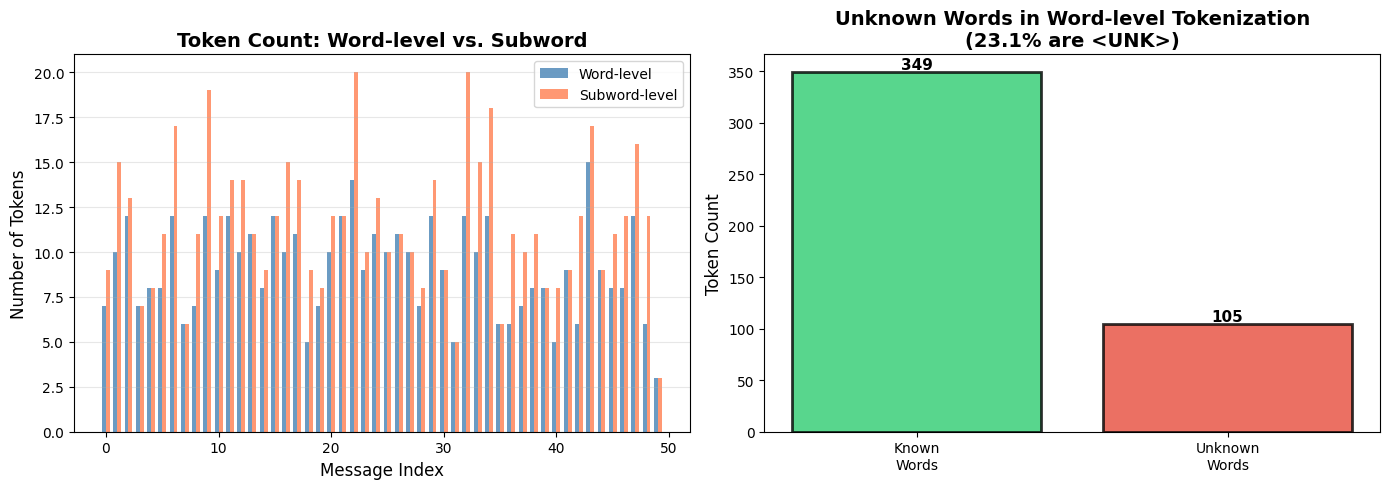


Tokenization Statistics:
  Average tokens per message (word-level): 9.1
  Average tokens per message (subword):    11.5
  Unknown words (word-level):              105/454 (23.1%)
  Unknown words (subword):                 0/576 (0.0%)


In [21]:
# Tokenize all messages with both methods
word_token_counts = []
subword_token_counts = []
word_unk_counts = []

for msg in messages:
    # Word-level
    word_indices = tokenizer.encode(msg)
    word_token_counts.append(len(word_indices))
    unk_count = sum(1 for idx in word_indices if idx == tokenizer.word2idx[tokenizer.UNK])
    word_unk_counts.append(unk_count)
    
    # Subword
    bert_tokens = bert_tokenizer.tokenize(msg)
    subword_token_counts.append(len(bert_tokens))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Token count comparison
ax = axes[0]
x = np.arange(len(messages))
width = 0.35

bars1 = ax.bar(x - width/2, word_token_counts, width, label='Word-level', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, subword_token_counts, width, label='Subword-level', alpha=0.8, color='coral')

ax.set_xlabel('Message Index', fontsize=12)
ax.set_ylabel('Number of Tokens', fontsize=12)
ax.set_title('Token Count: Word-level vs. Subword', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Unknown word statistics
ax = axes[1]
total_words = sum(word_token_counts)
total_unks = sum(word_unk_counts)
unk_percentage = (total_unks / total_words) * 100

categories = ['Known\nWords', 'Unknown\nWords']
values = [total_words - total_unks, total_unks]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Token Count', fontsize=12)
ax.set_title(f'Unknown Words in Word-level Tokenization\n({unk_percentage:.1f}% are <UNK>)', 
             fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nTokenization Statistics:")
print(f"  Average tokens per message (word-level): {np.mean(word_token_counts):.1f}")
print(f"  Average tokens per message (subword):    {np.mean(subword_token_counts):.1f}")
print(f"  Unknown words (word-level):              {total_unks}/{total_words} ({unk_percentage:.1f}%)")
print(f"  Unknown words (subword):                 0/{sum(subword_token_counts)} (0.0%)")

## Creating PyTorch Tensors for Neural Networks

Let's see how tokenized text becomes input for embeddings:

In [22]:
# Take a sample message
sample_msg = "I need help with my order please"

# Tokenize with BERT
bert_output = bert_tokenizer(
    sample_msg,
    padding=True,
    truncation=True,
    max_length=20,
    return_tensors='pt'  # Return PyTorch tensors
)

print(f"Original message: '{sample_msg}'")
print(f"\nTokens: {bert_tokenizer.tokenize(sample_msg)}")
print(f"\nPyTorch tensors ready for model:")
print(f"  input_ids shape:      {bert_output['input_ids'].shape}")
print(f"  attention_mask shape: {bert_output['attention_mask'].shape}")
print(f"\ninput_ids:")
print(f"  {bert_output['input_ids']}")
print(f"\nattention_mask (1=real token, 0=padding):")
print(f"  {bert_output['attention_mask']}")

print("\n✓ These tensors can now be fed into:")
print("  1. Embedding layer (input_ids)")
print("  2. Attention mechanism (attention_mask)")
print("  3. Transformer model")

Original message: 'I need help with my order please'

Tokens: ['i', 'need', 'help', 'with', 'my', 'order', 'please']

PyTorch tensors ready for model:
  input_ids shape:      torch.Size([1, 9])
  attention_mask shape: torch.Size([1, 9])

input_ids:
  tensor([[ 101, 1045, 2342, 2393, 2007, 2026, 2344, 3531,  102]])

attention_mask (1=real token, 0=padding):
  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])

✓ These tensors can now be fed into:
  1. Embedding layer (input_ids)
  2. Attention mechanism (attention_mask)
  3. Transformer model


## 🎯 Key Takeaways

1. **Sequential data is different:**
   - Order matters critically ("I didn't like it" ≠ "I like it")
   - Variable length is a challenge for neural networks
   - Temporal dependencies must be captured

2. **Tokenization pipeline:**
   ```
   Text → Tokens → Vocabulary → Indices → PyTorch Tensors → Embeddings
   ```

3. **Word-level tokenization:**
   - Simple to implement (split on whitespace)
   - Problem: Unknown words → information loss
   - Large vocabulary for good coverage

4. **Subword tokenization:**
   - Breaks rare words into known pieces
   - No unknown words!
   - Balanced vocabulary size (~30K)
   - Used by modern models (BERT, GPT, etc.)

5. **The vocabulary trade-off:**
   - Coverage vs. Memory vs. Context Length
   - Subword tokenization provides the best balance

**Bottom Line:** Modern subword tokenizers solve the unknown word problem by breaking rare words into known pieces, making them essential for real-world NLP applications!